### Практика
#### Предсказание дохода

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from comet_ml import Experiment
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score # для расчета площади ROC curve

%matplotlib inline

In [2]:
# Create an experiment with your api key
experiment = Experiment(
    api_key="Ra07S6KGK0XAiU2Cl59ZLcuyS",
    project_name="predict-income",
    workspace="dmitriy-b",
    log_code=True
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.com/dmitriy-b/predict-income/460ceae7396b40feb6f6167a46c9e9f3



In [3]:
training_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [4]:
# проверка размерности
training_data.shape, test_data.shape

((24420, 13), (8141, 13))

In [5]:
# задаем целевую переменную
target_name = 'income'

# выборки дели на X и y тренировочные и тестовые соответственно
X_train = training_data.drop(columns=[target_name])
y_train = training_data[target_name]

X_test = test_data.drop(columns=[target_name])
y_test = test_data[target_name]


In [6]:
# анализируем целевую переменную на тестовой выборке
print(y_test.value_counts(normalize=True))
print('Вывод: несбалансированная бинарная классификация')

0    0.763297
1    0.236703
Name: income, dtype: float64
Вывод: несбалансированная бинарная классификация


Статистика по числовым данным

In [7]:
X_train.describe().T


,count,mean,std,min,25%,50%,75%,max
age,24420.0,38.598116,13.638458,17.0,28.0,37.0,48.0,90.0
capital-gain,23705.0,1051.724067,7199.945441,0.0,0.0,0.0,0.0,99999.0
capital-loss,23936.0,88.409592,404.466154,0.0,0.0,0.0,0.0,4356.0
hours-per-week,24420.0,40.386568,12.299621,1.0,40.0,40.0,45.0,99.0


{'web': 'https://www.comet.com/api/image/download?imageId=1d65d154923540a49591dfa4e7a57f87&experimentKey=460ceae7396b40feb6f6167a46c9e9f3',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=1d65d154923540a49591dfa4e7a57f87&experimentKey=460ceae7396b40feb6f6167a46c9e9f3',
 'imageId': '1d65d154923540a49591dfa4e7a57f87'}

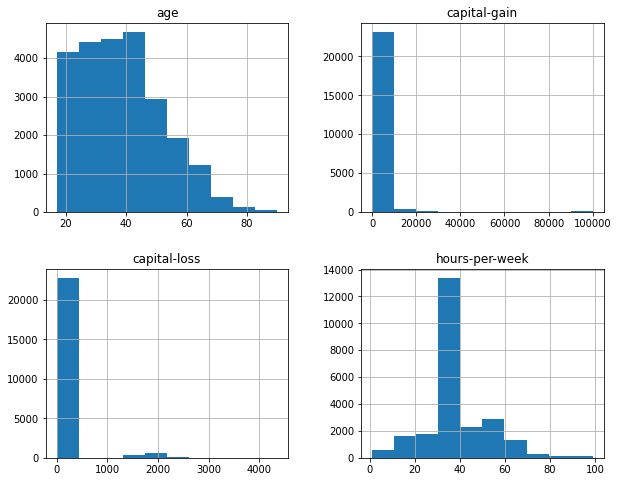

In [8]:
# строим гистограмму
X_train.hist(figsize=(10, 8))
#experiment.log_figure('X_train_numeric_distr', plt) # логируем гистограммы
experiment.log_figure('X_train_numeric_distr', plt)

1. Числовых признаков 4
2. Возраст 17 - 90 лет
3. Пропуски в capital-loss и capital-gain. По гисстограммам можно наблюдать, что большое количество значений в этих признаках нули.


#### Предобработка данных

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24420 entries, 0 to 24419
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             24420 non-null  int64  
 1   workclass       23223 non-null  object 
 2   education       23443 non-null  object 
 3   marital-status  24420 non-null  object 
 4   occupation      24420 non-null  object 
 5   relationship    24420 non-null  object 
 6   race            24420 non-null  object 
 7   sex             24420 non-null  object 
 8   capital-gain    23705 non-null  float64
 9   capital-loss    23936 non-null  float64
 10  hours-per-week  24420 non-null  int64  
 11  native-country  24420 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 2.2+ MB


- 8 признаков типа object
- 2 признака типа int64
- 2 признака типа float64
- 4 признака содержат пропуски

#### Обработка пропусков
<br>Тренировочную и тестовую выборки необходимо обрабатывать одинаково.
<br>Заполним capital-gain и capital-loss нулями т.к. они фокусируются в основном на нулевых значениях.

In [10]:
X_train['capital-gain'] = X_train['capital-gain'].fillna(0)
X_train['capital-loss'] = X_train['capital-loss'].fillna(0)

X_test['capital-gain'] = X_test['capital-gain'].fillna(0)
X_test['capital-loss'] = X_test['capital-loss'].fillna(0)

Признаки workclass и education категориальные, их заполним модой (частовстречающимися значениями)

In [11]:
X_train['workclass'].mode()

0    Private
Name: workclass, dtype: object

In [12]:
X_train['education'].mode()[0]

'HS-grad'

In [13]:
# моду смотрим на тренирововчной выборке, затем заполняем ею и тестовую выборку
X_train['workclass'] = X_train['workclass'].fillna('Private')
X_train['education'] = X_train['education'].fillna('HS-grad')

X_test['workclass'] = X_test['workclass'].fillna('Private')
X_test['education'] = X_test['education'].fillna('HS-grad')

#### Кодировка категориальных признаков
LabelEncoder и OneHotEncoder

In [14]:
'''# список категориальных признаков
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

# списко некатегориальных признаков
non_categorical_features = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']'''

"# список категориальных признаков\ncategorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']\n\n# списко некатегориальных признаков\nnon_categorical_features = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']"

In [15]:
# создадим списки наименований категориальных и некатегориальных признаков
categorical_features = []
non_categorical_features = []
for i in X_test.columns:
    if X_test[i].dtype == 'O':
        categorical_features.append(i)
    else:
        non_categorical_features.append(i)
        
#display (categorical_features, non_categorical_features)

In [16]:
X_train[categorical_features].head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
1,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States
2,Private,11th,Married-civ-spouse,Other-service,Husband,Black,Male,United-States
3,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,United-States
4,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,United-States


#### Используем метод порядкового кодирования LabelEncoder

In [17]:
# создадим копии выборок
X_train_le = X_train.copy()
X_test_le = X_test.copy()

# инициализируем метод кодирования
label_encoder = LabelEncoder()

# с помощью цикла закодируем признаки
for i in categorical_features:
    X_train_le[i] = label_encoder.fit_transform(X_train_le[i])
    X_test_le[i] = label_encoder.fit_transform(X_test_le[i])

In [18]:
X_train_le.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,49,4,11,2,3,0,4,1,0.0,0.0,40,39
1,27,4,11,2,7,0,4,1,0.0,0.0,45,39
2,44,4,1,2,8,0,2,1,0.0,0.0,60,39
3,59,4,9,5,1,4,4,1,0.0,0.0,60,39
4,54,4,9,0,12,1,4,0,0.0,1408.0,38,39


#### Используем метод горячего кодирования OneHotEncoder

In [19]:
# инициализация кодировщика
onehot_encoder = OneHotEncoder()

# Обучаем на тестовой выборке и сразу применяем кодирование к тойже тестовой выборке и запишем массив в новую переменную
X_train_onehot = onehot_encoder.fit_transform(X_train[categorical_features]).toarray()

# Обученную модель строкой ранее применяем к тестовой выборке и записываем массив в новой переменной
X_test_onehot = onehot_encoder.transform(X_test[categorical_features]).toarray()

# получим наименование новых колонок после кодирования и запишем в переменную
columns = onehot_encoder.get_feature_names(categorical_features) # 99 новых признаков

# новые таблицы трансформируем в DataFrame
X_train_onehot = pd.DataFrame(X_train_onehot, columns=columns)
X_test_onehot = pd.DataFrame(X_test_onehot, columns=columns)


c:\Users\dmitr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
# создаем новый дата-сет, где соединим X_train (т.к. там остались цифровые признаки) и X_train_onehot, так же и с тестовой выборкой
X_train_new = pd.concat([X_train, X_train_onehot], axis=1)
X_test_new = pd.concat([X_test, X_test_onehot], axis=1)

In [21]:
# из новых таблиц удалим исходные категориальные признаки
X_train_new = X_train_new.drop(columns=categorical_features)
X_test_new = X_test_new.drop(columns=categorical_features)


#### Обучение модели

Для классификатора используем логистическую регрессию

In [22]:
# инициализация модели линейной регрессии для таблицы с горячим кодированием OneHotEncoder
linear_model_oh = LogisticRegression()

# инициализация модели линейной регрессии для таблицы с порядковым кодированием LabelEncoder
linear_model = LogisticRegression()

In [23]:
# Обучение моделей
linear_model_oh.fit(X_train_new, y_train)

linear_model.fit(X_train_le, y_train)

c:\Users\dmitr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\dmitr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

LogisticRegression()

Валидация модели на тестовой выборке

In [24]:
prediction_oh = linear_model_oh.predict(X_test_new) # дата-сет кодировщик OneHotEncoder

In [25]:
prediction_le = linear_model.predict(X_test_le) # дата-сет кодировщик LabelEncoder

In [26]:
np.unique(prediction_oh)

array([0, 1], dtype=int64)

In [27]:
# анализируем присутствие элементов первого класса
print(sum(prediction_oh))
print(round(sum(prediction_oh)/len(prediction_oh),2), '%')

1586
0.19 %


In [28]:
# проанализируем сколько в действительности присутсвует единиц в y_test
print(sum(y_test))
print(round(sum(y_test)/len(y_test),2), '%')

1927
0.24 %


Проверка точности предсказания на метрике accuracy_score

In [29]:
acc_oh = accuracy_score(y_test, prediction_oh)
print(round(acc_oh, 3))

0.849


In [30]:
acc_le = accuracy_score(y_test, prediction_le)
print(round(acc_le, 3))

0.8


In [31]:
experiment.log_metric('Accuracy_score_LE', acc_le) # логирование

In [32]:
experiment.log_metric('Accuracy_score_OHE', acc_oh) # логирование

Модель, обученная на дата-сете закодированной методом OneHotEncoder показала лучше результат на 5%

Проверим точность модели через константный классификатор. Т.к. большинство класса - это ноль, то и будем использовать ноль в константном классификаторе.

In [33]:
print('Accuracy major class:', accuracy_score(y_test, np.zeros_like(y_test)).round(3))

Accuracy major class: 0.763


#### Таблица сопряженности модели классификации

Другой способ оценивать качество работы классификатора - использовать таблицу сопряженности. 


|                   |  Предсказано `0` |  Предсказано `1` |
|:-------------------|:------------------|:------------------|
|**Фактически** `0`  |       TN         |       FP         |
|**Фактически** `1`  |       FN         |       TP         | 


In [34]:
pd.DataFrame(confusion_matrix(y_test, prediction_oh))

,0,1
0,5769,445
1,786,1141


In [35]:
experiment.log_confusion_matrix(y_test, prediction_oh)

{'web': 'https://www.comet.com/api/asset/download?assetId=1f4ff1ddbe22433a83af3f6fffe52e62&experimentKey=460ceae7396b40feb6f6167a46c9e9f3',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=1f4ff1ddbe22433a83af3f6fffe52e62&experimentKey=460ceae7396b40feb6f6167a46c9e9f3',
 'assetId': '1f4ff1ddbe22433a83af3f6fffe52e62'}

#### Прогноз вероятности принадлежности к классу через _proba

In [36]:
pred_proba_oh = linear_model_oh.predict_proba(X_test_new)
pred_proba_oh

array([[0.94876711, 0.05123289],
       [0.37246102, 0.62753898],
       [0.2295452 , 0.7704548 ],
       ...,
       [0.99644379, 0.00355621],
       [0.37202903, 0.62797097],
       [0.68669756, 0.31330244]])

In [37]:
# выберем столбец вероятности принадлежности к 1 классу
pred_proba = pred_proba_oh[:, 1]
pred_proba

array([0.05123289, 0.62753898, 0.7704548 , ..., 0.00355621, 0.62797097,
       0.31330244])

Отобразим распределение предсказанной классификатором вероятности дохода более 50 тыс, 1 класс

{'web': 'https://www.comet.com/api/image/download?imageId=412fb34af7e54356b139fcdd09d576df&experimentKey=460ceae7396b40feb6f6167a46c9e9f3',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=412fb34af7e54356b139fcdd09d576df&experimentKey=460ceae7396b40feb6f6167a46c9e9f3',
 'imageId': '412fb34af7e54356b139fcdd09d576df'}

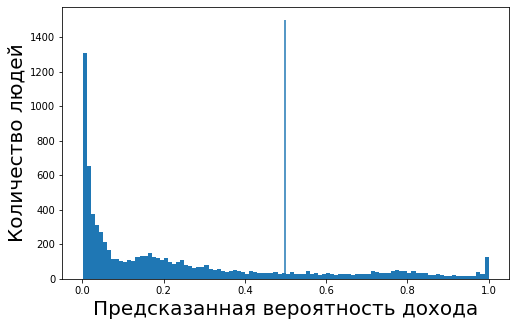

In [38]:
plt.figure(figsize=(8, 5))
plt.hist(pred_proba, bins=100)
plt.vlines(0.5, 0, 1500)

plt.xlabel('Предсказанная вероятность дохода', fontsize=20)
plt.ylabel('Количество людей', fontsize=20)

experiment.log_figure('predicted_income_probability', plt)

#### ROC кривая классификатора

Для дата-сета закодированного OneHotEncoder

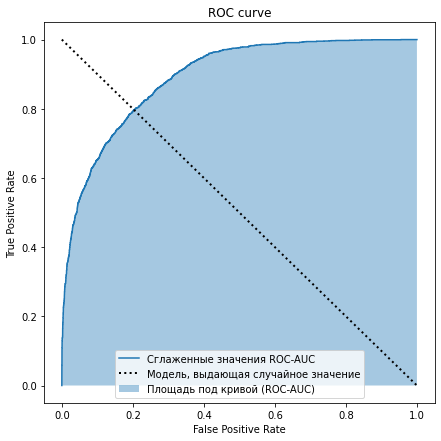

In [39]:
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, pred_proba)

# создаем roc-curve
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [1, 0], color='k', lw=2, linestyle=':', label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step='pre', alpha=0.4, label='Площадь под кривой (ROC-AUC)')

plt.legend()
plt.show()

In [40]:
# рассчет площади ROC curve
roc_auc = roc_auc_score(y_test, pred_proba).round(3)
print('ROC-AUC на тестовой выборке (oh)', roc_auc)

ROC-AUC на тестовой выборке (oh) 0.892


In [41]:
experiment.log_metric('roc_auc OneHot data', roc_auc)

Для дата-сета закодированного LabelEncoder

In [42]:
pred_proba_le = linear_model.predict_proba(X_test_le)
pred_proba_le

array([[0.70972943, 0.29027057],
       [0.95393521, 0.04606479],
       [0.64699814, 0.35300186],
       ...,
       [0.94395684, 0.05604316],
       [0.63560326, 0.36439674],
       [0.41032161, 0.58967839]])

In [43]:
# выберем столбец вероятности принадлежности к 1 классу
pred_proba_le = pred_proba_le[:, 1]
pred_proba_le

array([0.29027057, 0.04606479, 0.35300186, ..., 0.05604316, 0.36439674,
       0.58967839])

{'web': 'https://www.comet.com/api/image/download?imageId=4b95a8e786364bccae2a20f4c3d87ffa&experimentKey=460ceae7396b40feb6f6167a46c9e9f3',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=4b95a8e786364bccae2a20f4c3d87ffa&experimentKey=460ceae7396b40feb6f6167a46c9e9f3',
 'imageId': '4b95a8e786364bccae2a20f4c3d87ffa'}

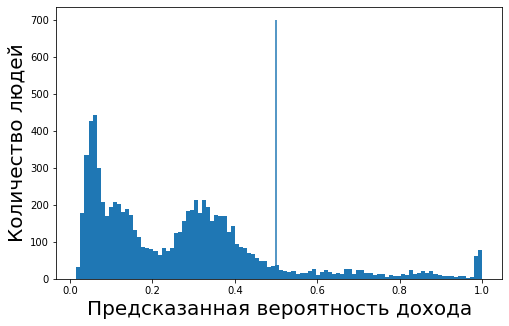

In [44]:
plt.figure(figsize=(8, 5))
plt.hist(pred_proba_le, bins=100)
plt.vlines(0.5, 0, 700)

plt.xlabel('Предсказанная вероятность дохода', fontsize=20)
plt.ylabel('Количество людей', fontsize=20)

experiment.log_figure('predicted_income_probability_le', plt)

Для дата-сета закодированного LabelEncoder

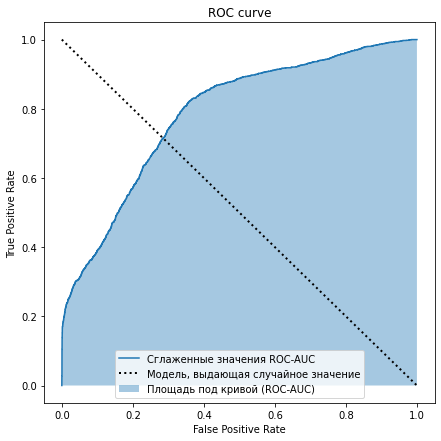

In [45]:
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, pred_proba_le)

# создаем roc-curve
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [1, 0], color='k', lw=2, linestyle=':', label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step='pre', alpha=0.4, label='Площадь под кривой (ROC-AUC)')

plt.legend()
plt.show()

In [46]:
# рассчет площади ROC curve
roc_auc_le = roc_auc_score(y_test, pred_proba_le).round(3)
print('ROC-AUC на тестовой выборке (le)', roc_auc_le)

ROC-AUC на тестовой выборке (le) 0.786


In [47]:
experiment.log_metric('roc_auc LabelEncoder data', roc_auc_le)

In [48]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/dmitriy-b/predict-income/460ceae7396b40feb6f6167a46c9e9f3
COMET INFO:   Metrics:
COMET INFO:     Accuracy_score_LE         : 0.8001474020390615
COMET INFO:     Accuracy_score_OHE        : 0.8487900749293699
COMET INFO:     roc_auc LabelEncoder data : 0.786
COMET INFO:     roc_auc OneHot data       : 0.892
COMET INFO:   Parameters:
COMET INFO:     C                 : 1.0
COMET INFO:     categories        : auto
COMET INFO:     class_weight      : 1
COMET INFO:     drop              : 1
COMET INFO:     dtype             : <class 'numpy.float64'>
COMET INFO:     dual              : False
COMET INFO:     fit_intercept     : True
COMET INFO:     handle_unknown    : error
COMET INFO:     intercept_scaling : 1
COMET INFO:     l1_ratio          : 1
COMET